### R-CNN Implementation Using Keras

## Step 1: read in dataset and draw bounding boxes on images

In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import pandas as pd
from PIL import Image
from PIL.ImageDraw import Draw


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 2: start building model

In [3]:
width = 416
height = 416
num_classes = 3
classes = ["Crab", "Shrimp", "Lobster"]

In [4]:
def load_and_process_data(csv_file, image_dir):
    image_records = pd.read_csv(csv_file)
    image_path = os.path.join(os.getcwd(), image_dir)

    images = []
    targets = []
    labels = []

    for index, row in image_records.iterrows():
        (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

        image_fullpath = os.path.join(image_path, filename)
        img = keras.preprocessing.image.load_img(image_fullpath, target_size=(height, width))
        img_arr = keras.preprocessing.image.img_to_array(img)

        xmin = round(xmin/ width, 2)
        ymin = round(ymin/ height, 2)
        xmax = round(xmax/ width, 2)
        ymax = round(ymax/ height, 2)

        images.append(img_arr)
        targets.append((xmin, ymin, xmax, ymax))
        labels.append(classes.index(class_name))

    return images, targets, labels

In [5]:
# load and preprocess datasets
TRAINING_CSV_FILE = '/content/drive/MyDrive/nnFinalProjectFiles/shellfish_dataset/train/_annotations.csv'
VALIDATION_CSV_FILE = '/content/drive/MyDrive/nnFinalProjectFiles/shellfish_dataset/valid/_annotations.csv'
TESTING_CSV_FILE = '/content/drive/MyDrive/nnFinalProjectFiles/shellfish_dataset/test/_annotations.csv'

TRAINING_IMAGE_DIR = '/content/drive/MyDrive/nnFinalProjectFiles/shellfish_dataset/train'
VALIDATION_IMAGE_DIR = '/content/drive/MyDrive/nnFinalProjectFiles/shellfish_dataset/valid'
TESTING_IMAGE_DIR = '/content/drive/MyDrive/nnFinalProjectFiles/shellfish_dataset/test'

train_images, train_targets, train_labels = load_and_process_data(TRAINING_CSV_FILE, TRAINING_IMAGE_DIR)
validation_images, validation_targets, validation_labels = load_and_process_data(VALIDATION_CSV_FILE, VALIDATION_IMAGE_DIR)
test_images, test_targets, test_labels = load_and_process_data(TESTING_CSV_FILE, TESTING_IMAGE_DIR)

In [6]:
#create the common input layer
input_shape = (height, width, 3)
input_layer = tf.keras.layers.Input(input_shape)

#create the base layers
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

In [7]:
#create the classifier branch
classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch)

In [8]:
#create the localiser branch
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)


In [9]:
# model = tf.keras.Model(input_layer, outputs=[classifier_branch, locator_branch])
model = tf.keras.Model(input_layer, outputs=locator_branch)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 416, 416, 3)]     0         
                                                                 
 bl_1 (Rescaling)            (None, 416, 416, 3)       0         
                                                                 
 bl_2 (Conv2D)               (None, 416, 416, 16)      448       
                                                                 
 bl_3 (MaxPooling2D)         (None, 208, 208, 16)      0         
                                                                 
 bl_4 (Conv2D)               (None, 208, 208, 32)      4640      
                                                                 
 bl_5 (MaxPooling2D)         (None, 104, 104, 32)      0         
                                                                 
 bl_6 (Conv2D)               (None, 104, 104, 64)      18496 

In [11]:
# for layer in model.layers:
#     if layer.name.startswith('bl_'):
#         print(layer.name)
#         layer.trainable = False

# for layer in model.layers:
#     if layer.name.startswith('bb_'):
#         print(layer.name)
#         layer.trainable = False

In [12]:
# losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "bb_head":tf.keras.losses.MSE}
losses = {"bb_head": tf.keras.losses.MSE}

In [13]:
# add optimizer (Adam)
# model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

In [14]:
# convert data to np.array
training_epochs = 5

train_images = np.array(train_images)
train_targets = np.array(train_targets)
train_labels = np.array(train_labels)

test_images = np.array(test_images)
test_targets = np.array(test_targets)
test_labels = np.array(test_labels)

validation_images = np.array(validation_images)
validation_targets = np.array(validation_targets)
validation_labels = np.array(validation_labels)

In [15]:
trainTargets = {
    # "cl_head": train_labels,
    "bb_head": train_targets
}

testTargets = {
    # "cl_head": test_labels,
    "bb_head": test_targets
}

In [16]:
history = model.fit(train_images, trainTargets,
                   validation_data=(test_images, testTargets),
                   batch_size=16,
                   epochs=training_epochs,
                   shuffle=True,
                   verbose=1)

Epoch 1/5
54/54 [==============================] - 19s 86ms/step - loss: 0.0578 - accuracy: 0.4720 - val_loss: 0.0511 - val_accuracy: 0.5603
Epoch 2/5
54/54 [==============================] - 3s 58ms/step - loss: 0.0437 - accuracy: 0.5408 - val_loss: 0.0568 - val_accuracy: 0.5345
Epoch 3/5
54/54 [==============================] - 3s 61ms/step - loss: 0.0374 - accuracy: 0.5944 - val_loss: 0.0551 - val_accuracy: 0.4310
Epoch 4/5
54/54 [==============================] - 4s 66ms/step - loss: 0.0338 - accuracy: 0.6166 - val_loss: 0.0569 - val_accuracy: 0.5345
Epoch 5/5
54/54 [==============================] - 3s 64ms/step - loss: 0.0312 - accuracy: 0.6399 - val_loss: 0.0631 - val_accuracy: 0.5431


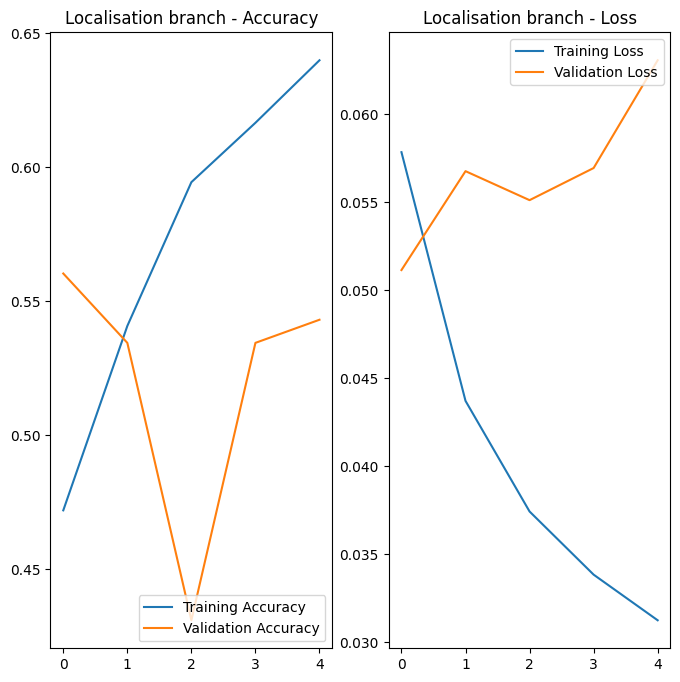

{'loss': [0.05783678591251373, 0.04370614513754845, 0.037421345710754395, 0.0338338278234005, 0.03124060481786728], 'accuracy': [0.4720279574394226, 0.5407925248146057, 0.5944055914878845, 0.616550087928772, 0.6398601531982422], 'val_loss': [0.05113895609974861, 0.056758057326078415, 0.055110491812229156, 0.05693567544221878, 0.06305809319019318], 'val_accuracy': [0.5603448152542114, 0.5344827771186829, 0.43103447556495667, 0.5344827771186829, 0.5431034564971924]}


In [17]:
# cl_accuracy = history.history['cl_head_accuracy']
# cl_val_acc = history.history['val_cl_head_accuracy']

# bb_accuracy = history.history['bb_head_accuracy']
# bb_val_acc = history.history['val_bb_head_accuracy']

# # cl_loss = history.history['cl_head_loss']
# # cl_val_loss = history.history['val_cl_head_loss']

# bb_loss = history.history['bb_head_loss']
# bb_val_loss = history.history['val_bb_head_loss']

bb_accuracy = history.history['accuracy']
bb_val_acc = history.history['val_accuracy']

# cl_loss = history.history['cl_head_loss']
# cl_val_loss = history.history['val_cl_head_loss']

bb_loss = history.history['loss']
bb_val_loss = history.history['val_loss']



epochs_range = range(training_epochs)


# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, cl_accuracy, label='Training Accuracy')
# plt.plot(epochs_range, cl_val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Classification branch - Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, cl_loss, label='Training Loss')
# plt.plot(epochs_range, cl_val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Classification branch - Loss')
# plt.show()

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, bb_accuracy, label='Training Accuracy')
plt.plot(epochs_range, bb_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Localisation branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, bb_loss, label='Training Loss')
plt.plot(epochs_range, bb_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Localisation branch - Loss')
plt.show()

print(history.history)

## Step 3: Test Model

1/1 [==============================] - 0s 84ms/step
[[0.16273183 0.15163004 0.7011383  0.8225236 ]]
1/1 [==============================] - 0s 69ms/step
[[0.17533268 0.2562271  0.74453145 0.82969457]]
1/1 [==============================] - 0s 31ms/step
[[0.26306605 0.23895462 0.73617196 0.76714003]]
1/1 [==============================] - 0s 87ms/step
[[0.17943388 0.24585287 0.762644   0.84292597]]
1/1 [==============================] - 0s 32ms/step
[[0.05210008 0.07380445 0.8485484  0.91523826]]


<Figure size 2000x2000 with 0 Axes>

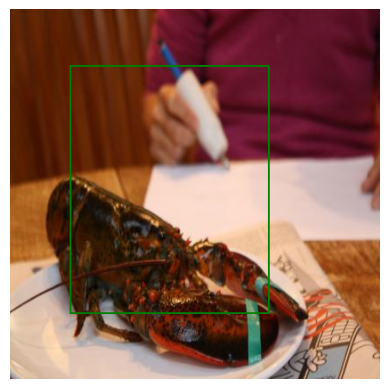

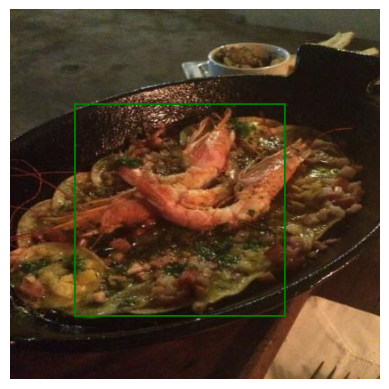

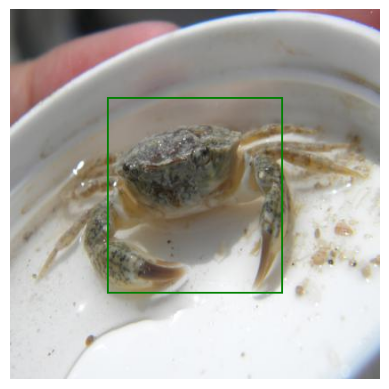

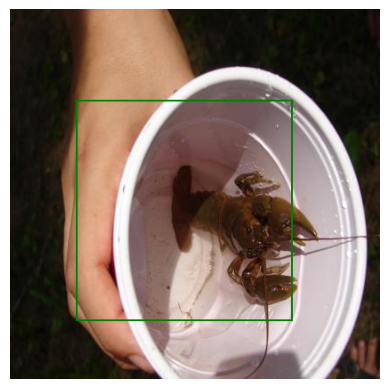

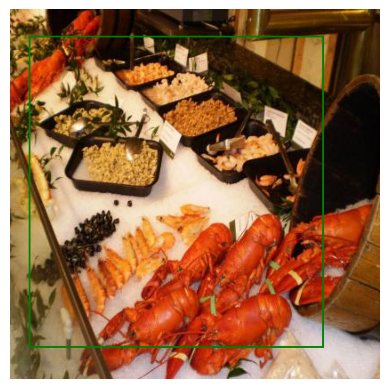

In [25]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

test_dir = pathlib.Path('/content/drive/MyDrive/nnFinalProjectFiles/shellfish_dataset/test')
img_paths = list(test_dir.glob('*.jpg'))

plt.figure(figsize=(20, 20))

for i, img_path in enumerate(img_paths[:5]):
    shellfish_img = keras.preprocessing.image.load_img(img_path, target_size=(height, width))
    img_arr = keras.preprocessing.image.img_to_array(shellfish_img)
    img_arr = tf.expand_dims(img_arr, 0)

    predictions = model.predict(img_arr)
    print(predictions)

    # for classification
    # score = tf.nn.softmax(predictions[0][0])

    # percent = int(round(100*np.max(score), 0))
    # print(classes)
    # print(np.argmax(score))
    # print(classes[np.argmax(score)])
    # class_name = classes[np.argmax(score)]
    # title = "{} - {} %".format(class_name, percent)

    bbox = predictions[0]
    bbox = [min(bbox[0], bbox[2]) * width, min(bbox[1], bbox[3]) * height, max(bbox[0], bbox[2]) * width, max(bbox[1], bbox[3]) * height]

    # if class_name == 'Shrimp':
    shellfish_img_arr = np.array(shellfish_img)
    cv2.rectangle(shellfish_img_arr, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 255, 255), 3)
    shellfish_img_arr_rgb = cv2.cvtColor(shellfish_img_arr, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(shellfish_img_arr_rgb)
    draw1 = Draw(shellfish_img)
    draw1.rectangle(bbox, outline='green', width=2)

    # if class_name == 'Lobster':
    #     shellfish_img_arr = np.array(shellfish_img)
    #     cv2.rectangle(shellfish_img_arr, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 255, 255), 3)
    #     shellfish_img_arr_rgb = cv2.cvtColor(shellfish_img_arr, cv2.COLOR_BGR2RGB)
    #     plt.figure()
    #     plt.imshow(shellfish_img_arr_rgb)
    #     draw1 = Draw(shellfish_img)
    #     draw1.rectangle(bbox, outline='red', width=2)

    # if class_name == 'Crab':
    #     shellfish_img_arr = np.array(shellfish_img)
    #     cv2.rectangle(shellfish_img_arr, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 255, 255), 3)
    #     shellfish_img_arr_rgb = cv2.cvtColor(shellfish_img_arr, cv2.COLOR_BGR2RGB)
    #     plt.figure()
    #     plt.imshow(shellfish_img_arr_rgb)
    #     draw1 = Draw(shellfish_img)
    #     draw1.rectangle(bbox, outline='blue', width=2)

    # ax = plt.subplot(29, 2, i+1)
    plt.imshow(shellfish_img)
    plt.axis("off")